In [1]:
%run uvms_dynamics.ipynb

jit after {'jit': True, 'jit_options': {'flags': '-Ofast'}, 'compiler': 'shell'}
number of joints = 4
floating_base found
floating_base found
floating_base found
floating_base found
floating_base found
floating_base found


In [2]:
# forward dynamics of uvms
x_next, states, u, parameters = rig_dyn.forward_dynamics(gravity=9.81, floating_base_id=fb_tau, floating_base_bias_f=B_F , J_uv = J_uv, coupled=True)

floating_base found
floating_base found
floating_base found
floating_base found
floating_base found
floating_base found


In [3]:
parameters

SX([G_0, G_1, G_2, G_3, Ir3_17, Ir3_16, Ir3_15, Ir3_14, Ir3_13, Ir3_12, Ir2_11, Ir2_10, Ir2_9, Ir2_8, Ir2_7, Ir2_6, Ir1_10, Ir1_8, Ir1_7, Ir1_6, Ir0_14, fw_static_0, fw_static_1, fw_static_2, fw_static_3, fw_viscous_0, fw_viscous_1, fw_viscous_2, fw_viscous_3, bw_static_0, bw_static_1, bw_static_2, bw_static_3, bw_viscous_0, bw_viscous_1, bw_viscous_2, bw_viscous_3, Ir1_11, Ir1_9, Ir0_12, Ir0_13, Ir0_16, Ir0_15, Ir0_17, M_A_coeff0_0, M_A_coeff0_1, M_A_coeff0_2, M_A_coeff0_3, M_A_coeff0_4, M_A_coeff0_5, M_A_coeff1_0, M_A_coeff1_1, M_A_coeff1_2, M_A_coeff1_3, M_A_coeff1_4, M_A_coeff1_5, M_A_coeff2_0, M_A_coeff2_1, M_A_coeff2_2, M_A_coeff2_3, M_A_coeff2_4, M_A_coeff2_5, M_A_coeff3_0, M_A_coeff3_1, M_A_coeff3_2, M_A_coeff3_3, M_A_coeff3_4, M_A_coeff3_5, D_u0_0, D_u0_1, D_u0_2, D_u0_3, D_u0_4, D_u0_5, D_u1_0, D_u1_1, D_u1_2, D_u1_3, D_u1_4, D_u1_5, D_u2_0, D_u2_1, D_u2_2, D_u2_3, D_u2_4, D_u2_5, D_u3_0, D_u3_1, D_u3_2, D_u3_3, D_u3_4, D_u3_5, D_uu0_0, D_uu0_1, D_uu0_2, D_uu0_3, D_uu0_4, D_u

In [4]:
parameters = cs.vertcat(parameters, ss.q_min, ss.q_max)
x_next_eval = cs.Function('UVMSnext', [states, u, parameters], [x_next])

In [5]:
# c , cpp or matlab code generation for forward dynamics
x_next_eval.generate("x_next_eval.c")
os.system(f"gcc -fPIC -shared x_next_eval.c -o libUVMS_coupled.so")

0

In [6]:
st_x0 = cs.vertcat(0,0,0,0,0,0, 0.9, 0.2, 0.6, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
u0 = cs.vertcat(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dt = 0.054321
p0 = cs.vertcat(rigid_body_p_est, trivial_Ir0, arm_Hyd__p_est, v_c0, dt, base_T0)


In [7]:
x_next_eval(st_x0, u0, cs.vertcat(p0, joint_min, joint_max))

DM([1.85484e-28, 2.23917e-28, 0, 2.3682e-26, -1.37417e-26, -1.66836e-26, 0.9, 1.5, 0.6, 0.2, 2.74467e-26, -2.81707e-26, 0, -2.9499e-24, -2.03611e-24, -2.70643e-25, 0, 0, 0, 9.01903e-26])

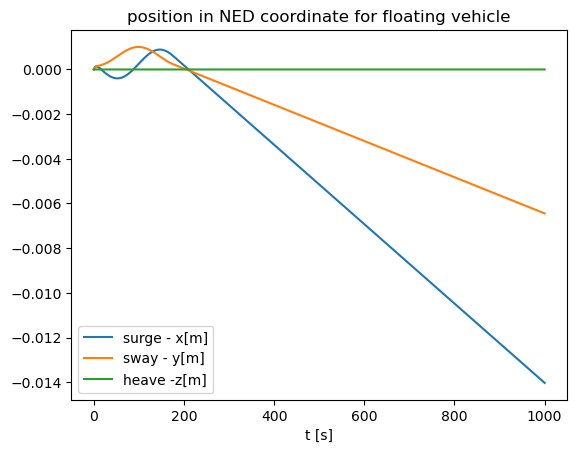

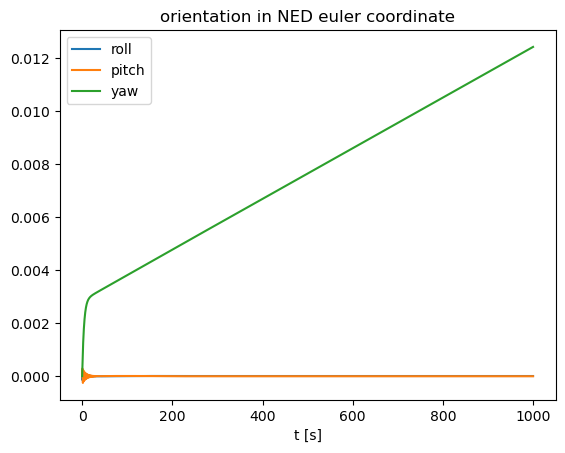

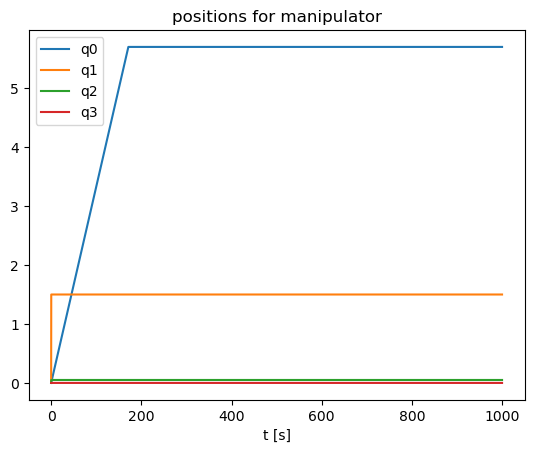

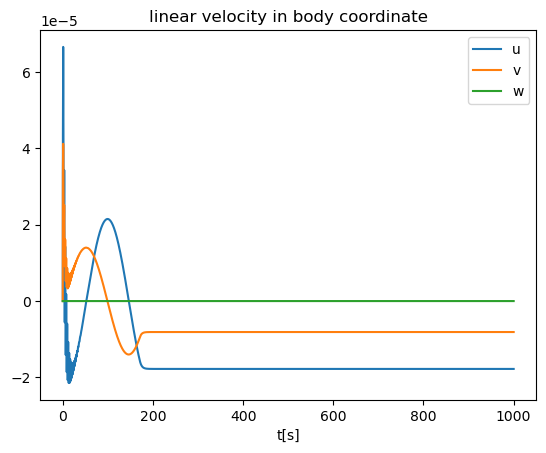

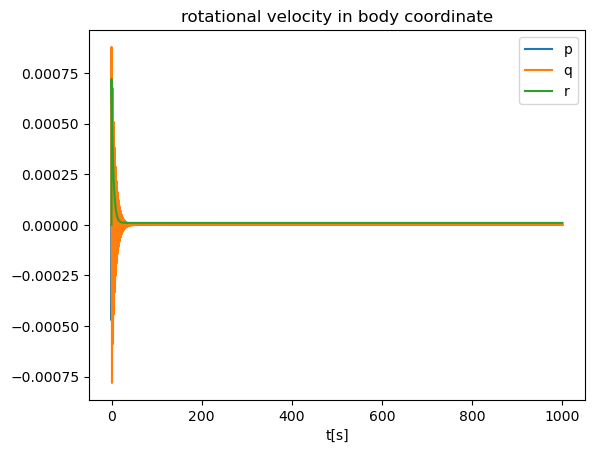

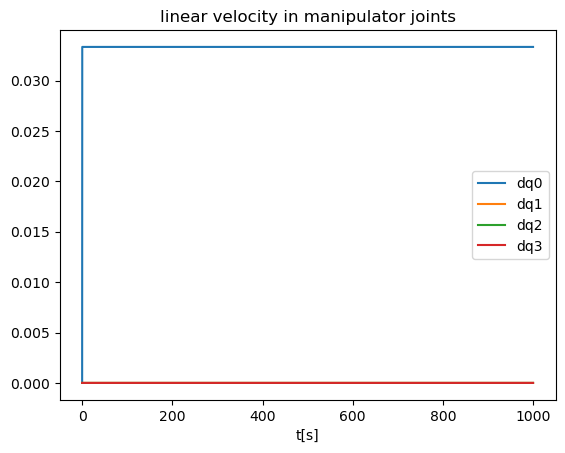

In [8]:
# SIMULATING vehicle on water surface
import matplotlib.pyplot as plt
T = 1000 # time horizon
dt = 0.05
N = int(T/dt) # number of control intervals
sim = x_next_eval.mapaccum(N)
x0 = np.array([0, 0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #x y z r p y q0 q1 q2 q3 u v w p q r qd0 qd1 qd2 qd3 qd4
u0 = np.array([0, 0.0, 0, 0, 0, 0, 0.1, 0, 0, 0])
p0 = cs.vertcat(rigid_body_p_est, trivial_Ir0, arm_Hyd__p_est, v_c0, dt, base_T0, joint_min, joint_max).full()
res = sim(x0, u0, p0)
t = np.linspace(0, T, N+1)


# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res.toarray()), axis=1)[0:3,:].T)
plt.legend(['surge - x[m]', 'sway - y[m]', 'heave -z[m]'])
plt.title("position in NED coordinate for floating vehicle")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res.toarray()), axis=1)[3:6,:].T)
plt.legend(['roll', 'pitch', 'yaw'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res.toarray()), axis=1)[6:10,:].T)
plt.legend(['q0', 'q1', 'q2', 'q3'])
plt.title("positions for manipulator")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res.toarray()), axis=1)[10:13,:].T)
plt.legend(['u', 'v', 'w'])
plt.xlabel('t[s]')
plt.title("linear velocity in body coordinate")
plt.show()

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res.toarray()), axis=1)[13:16,:].T)
plt.legend(['p', 'q', 'r'])
plt.xlabel('t[s]')
plt.title("rotational velocity in body coordinate")
plt.show()

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res.toarray()), axis=1)[16:20,:].T)
plt.legend(['dq0', 'dq1', 'dq2', 'dq3'])
plt.xlabel('t[s]')
plt.title("linear velocity in manipulator joints")
plt.show()